# Praca domowa nr 4
Adrianna Grudzień\
24.04.2021 r.

W ramach pracy domowej z przedmiotu Wstęp do uczenia maszynowego wykorzystałam algorytm Support Vector Machine (**SVM**). W tym celu wykorzystałam dwa różne zbiory danych.

Zbiór danych **apartments** z pakietu dalex dotyczy cen mieszkać w Warszawie.

Zbiór danych **australia.csv** zawiera codzienne obserwacje pogody z wielu australijskich stacji pogodowych.
Dane pochodzą z https://www.kaggle.com/jsphyg/weather-dataset-rattle-package. Zmienną docelową jest to, czy jutro deszcz będzie padał, czy też nie.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
np.random.seed = 42
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score, confusion_matrix, classification_report

# Zbiór `apartments` z pakietu dalex

### Wczytanie ramki danych

In [3]:
import dalex as dx
df = dx.datasets.load_apartments()
df.head() # trzeba zrobić kodowanie zmiennej district

,m2_price,construction_year,surface,floor,no_rooms,district
1,5897,1953,25,3,1,Srodmiescie
2,1818,1992,143,9,5,Bielany
3,3643,1937,56,1,2,Praga
4,3517,1995,93,7,3,Ochota
5,3013,1992,144,6,5,Mokotow


In [4]:
df.info() # brak nuli

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 1 to 1000
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   m2_price           1000 non-null   int64 
 1   construction_year  1000 non-null   int64 
 2   surface            1000 non-null   int64 
 3   floor              1000 non-null   int64 
 4   no_rooms           1000 non-null   int64 
 5   district           1000 non-null   object
dtypes: int64(5), object(1)
memory usage: 54.7+ KB


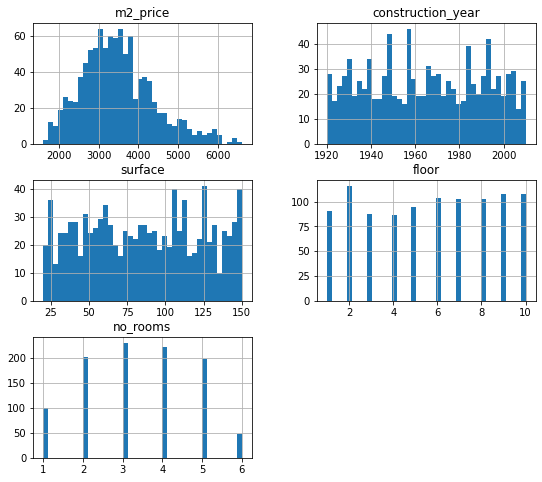

In [28]:
df.hist(figsize=(9,8), bins=40) # to nie jest w sumie takie potrzebne
plt.show()

### Kodowanie zmiennej `district`

In [5]:
# kodujemy zmienną district
from category_encoders import OneHotEncoder

encoder = OneHotEncoder(cols=['district'], use_cat_names=True).fit_transform(df['district'])
df = pd.concat([df.drop(['district'],axis=1),encoder], axis=1) # podmieniamy district na zakodowaną district
df.head(3)

,m2_price,construction_year,surface,floor,no_rooms,district_Srodmiescie,district_Bielany,district_Praga,district_Ochota,district_Mokotow,district_Ursus,district_Zoliborz,district_Wola,district_Bemowo,district_Ursynow
1,5897,1953,25,3,1,1,0,0,0,0,0,0,0,0,0
2,1818,1992,143,9,5,0,1,0,0,0,0,0,0,0,0
3,3643,1937,56,1,2,0,0,1,0,0,0,0,0,0,0


In [6]:
print('Minimalna cena w zbiorze:',df['m2_price'].min(), 'zł')
print('Mediana cen:',df['m2_price'].median(), 'zł')
print('Maksymalna cena w zbiorze:',df['m2_price'].max(), 'zł')

Minimalna cena w zbiorze: 1607 zł
Mediana cen: 3386.0 zł
Maksymalna cena w zbiorze: 6595 zł


### Podział zbioru

Naszą zmienną docelową będzie cena mieszkania w Warszawie `m2_price`.

In [9]:
from sklearn.model_selection import train_test_split

y = df['m2_price']
X = df.drop(['m2_price'],axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

### Model SVM

In [10]:
from sklearn.svm import SVR

In [11]:
# utworzenie modelu:
svr = SVR()
# trening:
svr.fit(X_train, y_train)

y_pred = svr.predict(X_test)

print('RMSE:', mean_squared_error(y_test, y_pred, squared=False)) # beznadziejny wynik

RMSE: 917.6207825964947


RMSE równy 918 to bardzo duży błąd w stosunku do rzędu wielkości cen mieszkań, których mediana wynosi 3386 zł.

### Skalowanie danych

Do skalowania używam StandardScaler.

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [13]:
svr_scaled = make_pipeline(StandardScaler(), SVR())

svr_scaled.fit(X_train, y_train)
y_pred = svr_scaled.predict(X_test)

print('RMSE:', mean_squared_error(y_test, y_pred, squared=False)) # beznadziejny wynik

RMSE: 895.1461436202234


Dla przypomnienia, bez skalowania RMSE wynosił 918. Tutaj jest to 895 - błąd się zmniejszył. Wniosek jest taki, że w tym przypadku skalowanie ulepszyło model.

### Optymalizacja parametrów

Korzystając z RandomSearchCV, przeprowadzam optymalizację hiperparametrów:
- cost,
- gamma,
- degree

In [14]:
from sklearn.model_selection import RandomizedSearchCV

In [15]:
param_svr = {
    'svr__C': [0.01, 0.1, 1, 10, 100],
    'svr__gamma': ['auto', 'scale', 0.01, 0.1, 1, 10, 100],
    'svr__degree': [1, 2, 3, 4, 5]
}

svr_randomized = RandomizedSearchCV(estimator=svr_scaled, param_distributions=param_svr,
                              n_iter=30, scoring='neg_root_mean_squared_error', n_jobs=-1)
svr_randomized.fit(X_train, y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('standardscaler',
                                              StandardScaler()),
                                             ('svr', SVR())]),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'svr__C': [0.01, 0.1, 1, 10, 100],
                                        'svr__degree': [1, 2, 3, 4, 5],
                                        'svr__gamma': ['auto', 'scale', 0.01,
                                                       0.1, 1, 10, 100]},
                   scoring='neg_root_mean_squared_error')

### Najlepsze parametry

In [16]:
svr_randomized.best_estimator_

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svr', SVR(C=100, degree=5, gamma='auto'))])

Sprawdźmy, czy podane parametry rzeczywiście są lepsze.

In [17]:
svr_optimized = make_pipeline(StandardScaler(), SVR(gamma='auto', C=100, degree=5))
svr_optimized.fit(X_train, y_train)

y_pred = svr_optimized.predict(X_test)
    
print('RMSE:', mean_squared_error(y_test, y_pred, squared=False))

RMSE: 275.85986963351706


Niesamowite. Z błędu wielkości 918 udało nam się spaść do RMSE = 276.

### Podsumowanie

Dla porównania spójrzmy na wszystkie otrzymane wyniki:

```R
RMSE:
ot tak 918
po skalowaniu 895
po optymalizacji 276
```

# Zbiór `australia.csv`

To samo robimy dla tego zbioru danych. Tym razem jednak traktujemy to jako klasyfikację, a nie regresję liniową. Będziemy porównywać accuracy, a nie RMSE.

### Wczytanie ramki danych

In [3]:
df = pd.read_csv('australia.csv')
df.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,17.9,35.2,0.0,12.0,12.3,48.0,6.0,20.0,20.0,13.0,1006.3,1004.4,2.0,5.0,26.6,33.4,0,0
1,18.4,28.9,0.0,14.8,13.0,37.0,19.0,19.0,30.0,8.0,1012.9,1012.1,1.0,1.0,20.3,27.0,0,0
2,19.4,37.6,0.0,10.8,10.6,46.0,30.0,15.0,42.0,22.0,1012.3,1009.2,1.0,6.0,28.7,34.9,0,0
3,21.9,38.4,0.0,11.4,12.2,31.0,6.0,6.0,37.0,22.0,1012.7,1009.1,1.0,5.0,29.1,35.6,0,0
4,24.2,41.0,0.0,11.2,8.4,35.0,17.0,13.0,19.0,15.0,1010.7,1007.4,1.0,6.0,33.6,37.6,0,0


In [24]:
df.info() # wszystko jest numeryczne i brak nuli - świetnie

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56420 entries, 0 to 56419
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MinTemp        56420 non-null  float64
 1   MaxTemp        56420 non-null  float64
 2   Rainfall       56420 non-null  float64
 3   Evaporation    56420 non-null  float64
 4   Sunshine       56420 non-null  float64
 5   WindGustSpeed  56420 non-null  float64
 6   WindSpeed9am   56420 non-null  float64
 7   WindSpeed3pm   56420 non-null  float64
 8   Humidity9am    56420 non-null  float64
 9   Humidity3pm    56420 non-null  float64
 10  Pressure9am    56420 non-null  float64
 11  Pressure3pm    56420 non-null  float64
 12  Cloud9am       56420 non-null  float64
 13  Cloud3pm       56420 non-null  float64
 14  Temp9am        56420 non-null  float64
 15  Temp3pm        56420 non-null  float64
 16  RainToday      56420 non-null  int64  
 17  RainTomorrow   56420 non-null  int64  
dtypes: flo

### Podział zbioru

Naszą zmienną docelową będzie to, czy jutro spadnie deszcze, czy nie - `RainTomorrow`.

In [4]:
from sklearn.model_selection import train_test_split

y = df['RainTomorrow']
X = df.drop(['RainTomorrow'],axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

### Model SVM

In [5]:
from sklearn.svm import SVC

In [41]:
# utworzenie modelu
svc = SVC()
# trening
svc.fit(X_train, y_train)

y_pred = svc.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred))

Accuracy: 0.8415455512229706


Można powiedzieć, że wynik jest całkiem niezły.

In [42]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.98      0.91     10979
           1       0.83      0.36      0.50      3126

    accuracy                           0.84     14105
   macro avg       0.84      0.67      0.70     14105
weighted avg       0.84      0.84      0.82     14105



Jak widać, model lepiej przewiduje brak deszczu niż deszcz, choć różnica jest nieznaczna.

### Skalowanie danych

Do skalowania używam StandardScaler.

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [9]:
svc_scaled = make_pipeline(StandardScaler(), SVC())

svc_scaled.fit(X_train, y_train)
y_pred = svc_scaled.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred))

Accuracy: 0.8562211981566821


Po przeskalowaniu otrzymaliśmy minimalnie lepszy wynik - z 84.2% do 85.6%.

### Optymalizacja parametrów

Korzystając z RandomSearchCV, przeprowadzam optymalizację hiperparametrów:
- cost,
- gamma,
- degree

In [11]:
from sklearn.model_selection import RandomizedSearchCV

In [12]:
param_svc = {
    'svc__C': [0.01, 0.1, 1, 10, 100],
    'svc__gamma': ['auto', 'scale', 0.01, 0.1, 1, 10, 100],
    'svc__degree': [1, 2, 3, 4, 5]
}

svc_randomized = RandomizedSearchCV(estimator=svc_scaled, param_distributions=param_svc,
                              n_iter=15, scoring='accuracy', n_jobs=-1)
svc_randomized.fit(X_train, y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('standardscaler',
                                              StandardScaler()),
                                             ('svc', SVC())]),
                   n_iter=15, n_jobs=-1,
                   param_distributions={'svc__C': [0.01, 0.1, 1, 10, 100],
                                        'svc__degree': [1, 2, 3, 4, 5],
                                        'svc__gamma': ['auto', 'scale', 0.01,
                                                       0.1, 1, 10, 100]},
                   scoring='accuracy')

### Najlepsze parametry

In [13]:
svc_randomized.best_estimator_

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=10, degree=2, gamma='auto'))])

Sprawdźmy, czy podane parametry rzeczywiście są lepsze.

In [15]:
svc_optimized = make_pipeline(StandardScaler(), SVC(random_state=1,gamma='auto', C=10, degree=2))
svc_optimized.fit(X_train, y_train)

y_pred = svc_optimized.predict(X_test)
    
print('Accuracy:', accuracy_score(y_test, y_pred))

Accuracy: 0.8596951435661113


### Podsumowanie

Dla porównania spójrzmy na wszystkie otrzymane wyniki:

```R
Accuracy:
ot tak 84.2%
po skalowaniu 85.6%
po optymalizacji 86.0%
```
Jak widzimy, najlepsza trafność cechuje model zoptymalizowany, choć różnica jest niewielka.

**Ogólne podsumowanie:** Zalinkowany artykuł (http://pyml.sourceforge.net/doc/howto.pdf) słusznie zwraca uwagę na skalowanie danych - w przypadku obu zbiorów danych skalowanie zwiększyło dokładność przewidywania wartości.

A już w ogóle najlepiej jest optymalizować parametry - wyniki są jeszcze dokładniejsze.